<a href="https://colab.research.google.com/github/IreneMuiaM/Credrails_Assesment/blob/main/Nomba_Classification_GTB_Account.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
from pathlib import Path
from google.colab import drive

import pandas as pd
import json

In [ ]:
BASE_DIR=Path().resolve().parent
GDRIVE_MOUNT=BASE_DIR/"gdrive"
DATA_DIR = GDRIVE_MOUNT /"MyDrive/Classification_MLs/data"
INPUT_DIR = DATA_DIR / "input"

drive.mount(GDRIVE_MOUNT.as_posix(), force_remount=True)

Mounted at /gdrive


In [ ]:
NombaGTB_FSP_Account=pd.read_csv(INPUT_DIR/"Nomba_Classification_acc_3_GTB_fsp.csv")

In [ ]:
NombaGTB_FSP_Account.head(2)

,id,transaction_date,value_date,transaction_type,amount,amount_currency,balance,balance_currency,matching_reference,reporting_tag,...,updated,fsp_accounts,fsp_transaction_ids,backend_accounts,backend_transaction_ids,other_accounts,other_transaction_ids,metadata,tags,description
0,170474017,2023-05-03 00:00:00.000000 UTC,2023-05-03 00:00:00.000000 UTC,C,4657.87,NGN,17416633.12,NGN,[],others,...,2023-05-04 12:36:37.076009 UTC,NaN,NaN,NaN,NaN,NaN,NaN,{original_reference=0fb5beeb-7b8b-4452-8766-89...,[others],NaN
1,170474018,2023-05-03 00:00:00.000000 UTC,2023-05-03 00:00:00.000000 UTC,C,62079.21,NGN,17478712.33,NGN,[],others,...,2023-05-04 12:36:37.076009 UTC,NaN,NaN,NaN,NaN,NaN,NaN,{original_reference=d3ba223e-a477-4776-bd7e-a9...,[others],NaN


In [ ]:
import ast
import re

# Extracting metadata - original_reference and tags

def column_extract(df):
  df["metadata2"]=df["metadata"].apply(lambda x: x.replace("="," : "))
  df["metadata2"] = df["metadata2"].str.replace('{', '{"').str.replace(', ', ', "').str.replace(' :', '":')
  df["metadata2"] = \
  df["metadata2"].str.replace('}', '"}').str.replace(': ', ': "').str.replace(', "', '", ').str.replace(', ',', "').str.replace('"[','[').str.replace(']"',']')
  df["metadata2"] = df["metadata2"].apply(lambda x: ast.literal_eval(x))

  df['O_reference'] = df['metadata2'].apply(lambda x: x.get('original_reference', None))
  df['Extract_tag'] = df['metadata2'].apply(lambda x: x.get('tags', None))
  return df

# Extracting reference number

def ref_extract(df):
  df['ref_no']=df["description"].str.extract(r'REF:([^\s]+)',flags=re.IGNORECARE)
  return df


In [ ]:
NombaGTB_FSP_Account2=column_extract(NombaGTB_FSP_Account)

In [ ]:
NombaGTB_FSP_Account2.columns

Index(['id', 'transaction_date', 'value_date', 'transaction_type', 'amount',
       'amount_currency', 'balance', 'balance_currency', 'matching_reference',
       'reporting_tag', 'is_reversal', 'is_duplicate',
       'is_duplicate_parent_reference', 'matched', 'reversal', 'client_id',
       'account_id', 'batch_id', 'created', 'updated', 'fsp_accounts',
       'fsp_transaction_ids', 'backend_accounts', 'backend_transaction_ids',
       'other_accounts', 'other_transaction_ids', 'metadata', 'tags',
       'description', 'metadata2', 'O_reference', 'Extract_tag'],
      dtype='object')

In [ ]:
# unique tags
NombaGTB_FSP_Account2['tags'].unique()

array(['others', 'chargebacks', 'transfers', 'charges', 'withdrawals'],
      dtype=object)

In [ ]:
# Cleaning_tag_names
def clean_tag(df):
  df['tags'] = df['tags'].str.replace("unknown_pattern","").str.replace("no_ref","").str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.lower()
  return df

In [ ]:
NombaGTB_FSP_Account3=clean_tag(NombaGTB_FSP_Account2)

In [ ]:
NombaGTB_FSP_Account3['tags'].unique()

array(['others', 'chargebacks', 'transfers', 'charges', 'withdrawals'],
      dtype=object)

In [123]:
# Filter data for training
def filter_data(df):
  df=df.loc[(df['tags']!='others') & (df['description']!= None)]
  df_cleaned=df.dropna(axis=0,subset=['description'])
  return df_cleaned

def filter_data2(df):
  df_cleaned=df.dropna(axis=0,subset=['description'])
  return df_cleaned

In [125]:
NombaGTB_FSP_Account4=filter_data(NombaGTB_FSP_Account3)
NombaGTB_FSP_Account3_1=filter_data2(NombaGTB_FSP_Account3)
print(NombaGTB_FSP_Account3.shape)
print(NombaGTB_FSP_Account4.shape)
print(NombaGTB_FSP_Account3_1.shape)

(30200, 32)
(768, 32)
(941, 32)


In [126]:
NombaGTB_FSP_Account4['tags'].unique()

array(['transfers', 'charges', 'withdrawals'], dtype=object)

In [127]:
# @title Model Training

# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [128]:
#@title Data Preprocessing
NombaGTB_FSP_Account4['description']=NombaGTB_FSP_Account4['description'].str.lower()

In [129]:
# Split_data

x_train,x_test,y_train,y_test=train_test_split(NombaGTB_FSP_Account4['description'],NombaGTB_FSP_Account4['tags'],test_size=0.3,random_state=42)

# Feature extraction using TF-IDF Vectorizer
vectorizer=TfidfVectorizer()
x_train_tfidf=vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.transform(x_test)

# Train Naive Bayes Model
nb=MultinomialNB()
nb.fit(x_train_tfidf,y_train)

# Make prediction
y_pred=nb.predict(x_test_tfidf)

# Evaluate the model
accuracy=accuracy_score(y_test,y_pred)
report=classification_report(y_test,y_pred)

#ouptut results

print("Accuracy",accuracy)
print("classification Report:\n",report)

Accuracy 0.9956709956709957
classification Report:
               precision    recall  f1-score   support

     charges       1.00      1.00      1.00        48
   transfers       0.99      1.00      1.00       182
 withdrawals       0.00      0.00      0.00         1

    accuracy                           1.00       231
   macro avg       0.66      0.67      0.67       231
weighted avg       0.99      1.00      0.99       231



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


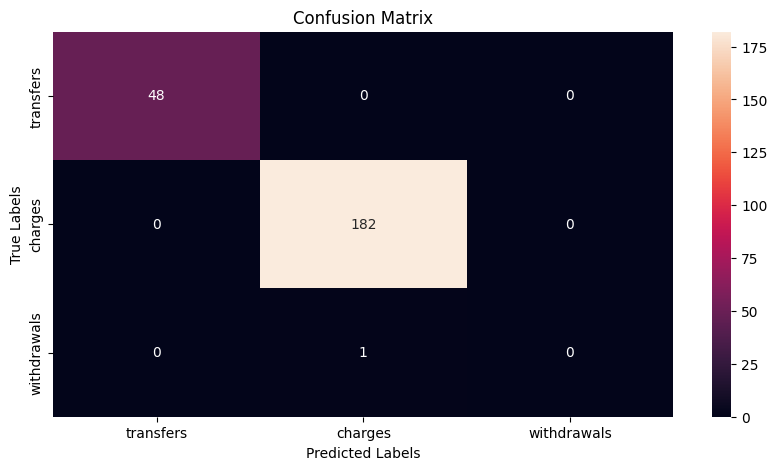

In [130]:
plt.figure(figsize=(10,5))
matrix=confusion_matrix(y_test,y_pred)
sns.heatmap(matrix,annot=True,fmt='d',xticklabels=NombaGTB_FSP_Account4['tags'].unique(),yticklabels=NombaGTB_FSP_Account4['tags'].unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [131]:
def ouput(df):
  df['predicted_tags']=nb.predict(vectorizer.transform(df['description']))
  df['correct_classification']=df.apply(lambda row : row['predicted_tags']==row["tags"], axis=1)
  return df

In [132]:
NombaGTB_FSP_ouput=ouput(NombaGTB_FSP_Account4)
NombaGTB_FSP_ouput2=ouput(NombaGTB_FSP_Account3_1)

<ipython-input-131-3afe88336464>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_tags']=nb.predict(vectorizer.transform(df['description']))
<ipython-input-131-3afe88336464>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['correct_classification']=df.apply(lambda row : row['predicted_tags']==row["tags"], axis=1)


In [133]:
NombaGTB_FSP_ouput["correct_classification"].value_counts()

,count
correct_classification,
True,766
False,2


In [122]:
example=NombaGTB_FSP_ouput.loc[NombaGTB_FSP_ouput["correct_classification"]==False]
example[['description',"predicted_tags","tags"]]

,description,predicted_tags,tags
1746,d | other transaction rvsl of duplicated neft/...,transfers,withdrawals
1747,d | other transaction rvsl of duplicated neft/...,transfers,withdrawals


In [134]:
# @title Load data to google Drive

# Specify the path to save the file
file_path = '/content/drive/MyDrive/Classification_MLs/data/output/NombaGTB_FSP_ouput2.csv'

# Save the DataFrame to the specified location
NombaGTB_FSP_ouput2.to_csv(file_path, index=False)